# Random walk on a Random environment

Let $\mathbb{Z}$ be the set of integers, we are going to define a **Simple Exclusion Process** $X_t$ on $\mathbb{Z}$ in order  to define a random environment and above that another particle will do **Random walk** over this random environment.

In time $t=0$ for each $i \in \mathbb{Z}$ is drawn independently from a Bernoulli $\frac{1}{2}$ distribution to define if there is a particle in position $i$ or if there is no particle in that place. When times passes from $t=0$ to $t=1$, the environment changes with the following rule.

- $n$ is drawn from a *Poisson* distribution of mean $v$ (v means the velocity of the environment).
- $n$ particles are chosen (with replacement) to move. The order that we choose the particles to move matters.
- For each particle *to move*, if the position of the particle is $i$ then the new position of that particle is $i-1$ or $i+1$ with the same probability, but the particle only moves to that new position if there is no other particle occupying the same space.

Between the interchanges of the environment a (discrete) **Random walk** is done.

- The random walk starts at position $0$, that is $X_0=0$.
- If the random walk is at position where there is a particle, then the random walk has a *left drift*, which means the probability of the random walk to go to the right neighbor is $1/3$ and the probability to go to the left neighbor is $2/3$.
- Otherwise the random walk is in a position without particle and there is a *right drift*, which means the probability to go to left is $1/3$ and the probability to go to the right is $2/3$.

**Remark**: the random walk does not affect the movement of the environment particles.
The main goal of the following code is to simulate a box of this process and try to estimate the coefficient of diffusion of this process.
It is somehow believed that $\mathbb{E}|X_t|\sim a_0 t^\gamma$. We call this coefficient $\gamma$ *coefficient of diffusion*.




## Update

- Create functions `particle_to_move()` and `move_all()`. 
- Change the representation of the particles.

Now the movement of environment particles and the random walk is done by the same function `move_all()` and also the current position of the particles and the random walk is saved in the same array.

If $L$ is the size of the environment and $mu$ is the density of particles `space_env()` still keeps the first $\lfloor L \cdot mu \rfloor$ entries to memorize the positions of the particles, but the last entry is reserved for the random walk position.

For example, `space_env = [0,3,5,6,3]`, which means that the first particle is at position 0, the second one is at 3, so on, and the random walk is at position 3 (together with a particle). The random walk can take negative values but the particles can't. For example, in `space_env = [10, 12, 15, 0, 2, 3, 4, -2]`. 

The `particle_to_move()` function returns `to_move`,`to_dir_l`,`to_dir_r` arrays of the same size, `to_move` indicates the particle or random walk moves and `to_dir_l` or `to_dir_r` indicates the direction to move,

The `move_all()` function takes `space_env`, `to_move`, `to_dir_l`, `to_dir_r` and `L` as input, then moves all particles of `to_move` accordingly with the instructions of `to_dir_l` or `to_dir_r`, it needs two arrays for directions because random walk has different behavior when it is at a particle (`to_dir_l`) or when random walk is not at a particle (`to_dir_r`).


`to_move` is an array with particles indexes or random walk index (the last one index of space_env), which chooses which particle or random walk is moving. 
`to_dir_l` is an array of $[-1,1]$ values. If it is a particle that is moving, it as sampled by a Bernoulli(1/2), if it is the random walk moving then it is sampled by a Bernoulli(`left_drift`).
`to_dir_l` is an array of $0$'s if a particle is moving, but if it is the random walk moving then it contains $[-1,1]$ values sampled by a Bernoulli(`right_drift`).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.stats import bernoulli

def space_env(L , mu=0.5):
    total_space = np.arange(L)
    space = np.random.choice(total_space, int(L*mu), replace=False)  # choose L/2 of the bins to contain a particle
    space = np.sort(space)
    space = np.append(space,[0])
    return(space)                                           # return the index of the particles sorted


# example of use

# defining parameters
L = 10      # number of size space simulated

test = space_env(L)
print(test)
mu = 0.2
test2 = space_env(L,mu)
print(test2)

# the last one entry of space is always related to the positions of the random walk, that starts at 0

[0 1 2 4 7 0]
[0 4 0]


In [2]:
def search(space,L,old_idx=0): # This function checks if the position of rw(space[-1]) is at some particle
    a = (space[-1])%L 
    numbpart = len(space)-1
    left,right = (old_idx%numbpart),((old_idx+1)%numbpart)

    if space[left]== a:
        return True,left
    if space[right]==a:
        return True,left
    
    if (space[left]> space[right]):  # in that case there is a jump between left and right
        if a> space[left] or space[right]>a:
            return False, left

    # Determine a properly sorted interval [left, right]
    while (space[left]> a)and(space[(left-1)%numbpart]<space[left]):
        # first part checks if      a < left
        # second part checks for a jump
        left = (left - 1)%(numbpart)
    while (space[right]<a)and(space[right]<space[(right+1)%numbpart]):
        # first part checks if right < a
        # second part checks for a jump
        right = (right + 1)%(numbpart)    
    # Binary search on [left,right]
    while left <= right:
        mid = (left+right)//2
        if space[mid] == a:
            return True,left
        
        if space[mid]< a<=space[right]:
            left = mid+1
        elif space[left]<= a < space[mid]:
            right = mid-1
        else:
            return False,left
    return False,left

In [3]:
# example of use

# defining parameters
L = 10      # number of size space simulated

test = [5,7,9,1,3,0]
test[-1] = 1
old_idx = 4 # the index of last seen particle
print('space =',test)

b,left_idx =search(test,L,old_idx)
print(left_idx)
print(b)

space = [5, 7, 9, 1, 3, 1]
3
False


In [4]:
def pipeline_to_move(space,s,l_drift=1/3, r_drift=2/3,v=1):
    # space is a vector with index of particles and the random walk in the last
    # s is the number of steps taken by the random walk
    numb_particles = len(space) -1                   # subtract one to not count rw as a particle
    p_index = np.arange(numb_particles)      # enumerating the particles
    p_steps = np.random.poisson(v*numb_particles,s)+1
    total = np.cumsum(p_steps)              # determining the times whether random walks jumps
    to_move = np.random.choice(p_index,total[-1])# determining which particle/rw jumps each time
                
    to_dir_l = np.random.choice([-1,1],total[-1])      # determining the vector of the directions to jump
    to_dir_r = np.zeros(total[-1])                     # to avoid bugs
    for n in total:                                    # random walk steps
        to_dir_l[n-1] = 2*np.random.binomial(1,l_drift) -1 # sampling rw steps if there is a particle
        to_dir_r[n-1] = 2*np.random.binomial(1,r_drift) -1 # sampling rw steps if there is not a particle
        to_move[n-1]= numb_particles
        
    return to_move,to_dir_l,to_dir_r

# example  of use
L=4
space = space_env(L)
s=3
to_mo, to_dir_l,  to_dir_r = pipeline_to_move(space,s)
print(to_mo)
print(to_dir_l)
print(to_dir_r)


[1 1 1 0 2 1 2 1 1 1 2]
[-1  1  1 -1  1  1 -1  1 -1 -1  1]
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]


In [5]:
def can_particle_move(space, L, i, dir_l): # Boolean saying if the particle i can move dir_l
    numb_particles = len(space)-1
    actual_pos= space[i] 
    new_pos = (actual_pos + dir_l)%L
    next_part_idx = (i + dir_l)% numb_particles
    next_part_pos = space[next_part_idx]

    return new_pos != next_part_pos


In [6]:
def move_all(space,L,to_move,to_dir_l,to_dir_r,old_part=0):
    numb_particles = len(space)-1
    for i,dir_l,dir_r in zip(to_move,to_dir_l,to_dir_r):
        if i == numb_particles:                     # i is the rw to_move
            rw_isinpart, old_part = search(space,L,old_part)
            if rw_isinpart:        # rw is at a particle
                space[-1] = space[-1] + dir_l
            else:                                       # rw is not at a particle       
                space[-1] = space[-1] + dir_r
        else:                                       # i is a particle to move
            if can_particle_move(space,L,i,dir_l):  # if particle i can move 
                space[i] = (space[i] + dir_l)%L     # Move the particle

# example of use
L = 8
space = space_env(L)
print(space)
s=9
to_mov, to_dir_l,to_dir_r = pipeline_to_move(space,s)
move_all(space,L,to_mov, to_dir_l,to_dir_r)
print(space)


[2 3 4 7 0]
[1 4 5 6 1]


In [7]:
def rw(L,s=L+1,mu=1/2,l_drift=1/3,r_drift=2/3,v=1):
    space = space_env(L,mu)
    to_move,to_dir_l,to_dir_r = pipeline_to_move(space,s,l_drift,r_drift,v)
    move_all(space,L,to_move,to_dir_l,to_dir_r)
    return space[-1] # returns the position of the random walk


# example of use
L=10
randomwalk=rw(L)
print('randomwalk =',randomwalk)

randomwalk = 5


In [8]:
def generate_data(Numbsimul,L,t=L+1,mu=1/2,l_drift=1/3,r_drift=2/3,v=1):
    # L,v,t,mu  are exactly thte same parameters used in random_walk
    # N is the number of simulations made

    data = np.array([rw(L,t,mu,l_drift,r_drift,v) for i in range(Numbsimul)])
    return(data)


def full_data_random_walk(k1,k2,Numbsimul,mu=1/2,l_drift=1/3,r_drift=2/3,v=1):
# k_1 is the minum size simulation and k2 is biggest 
    if k2<=k1:
        print('------------k2 must be bigger than k1-----------')
        return('error')

    start_time = time.time()

    # (L,v,t,mu) are exactly the same parameters used in random walk

    data = np.zeros((k2+1-k1, Numbsimul))

    for i, k in tqdm(enumerate(range(k1, k2+1))):
        n = pow(2,k)
        data[i,:] = np.array(generate_data(Numbsimul,n,n+1,mu,l_drift,r_drift,v))
    print('\n')
    print("--- %s seconds ---" % (time.time() - start_time))
    print('\n')

    return(data)


# example of use
k1=3 
k2=6
Numbsimul=10

A = full_data_random_walk(k1,k2,Numbsimul)
print(A)


4it [00:00, 165.97it/s]



--- 0.040863037109375 seconds ---


[[  7.  -5.   3.  -3.   3.   3.  -5.   3.   1.   1.]
 [  3.   7.  -5.   3.   1.   3.   3.  -7.   1.   3.]
 [ -1.   1.   1.   3.  -3.  -7.   3.  -3.   1.  11.]
 [ 13.  -1.   5.   9. -11.  13.   3.  11. -11.   7.]]


5it [01:02, 12.60s/it]



--- 62.977381229400635 seconds ---


 ---- diffusion constant is approximally 0.49713306571687327 using quantile 0.55 ----
 ---- diffusion constant is approximally 0.7562242424221074 median ----
 ---- diffusion constant is approximally 0.5711958526533399 mean ----


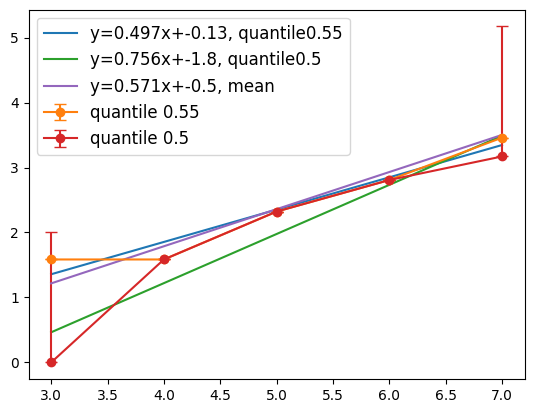

In [9]:
from loglogplot import log_log_plot

k1 = 3
k2 = 7
Numbsimul = 10000
A = full_data_random_walk(k1,k2, Numbsimul)

# Making the graphic of log_log_plot
q = 0.55
dom = np.arange(k1,k2+1)
log_log_plot(q,dom,A)